# 2020 SEG Annual Meeting Machine Learning Interpretation Workshop

In [24]:
import os  
import numpy as np
from time import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import architecture as a
import data as d
from PatchExtractor import PatchExtractor as PE
from utils import normalize_only, normalize

seed = 0
np.random.seed(seed)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams
from plotting import plot_label
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams.update({
    'image.cmap'     : 'gray',
    'axes.grid'      : False,
    'savefig.dpi'    : 300,  # to adjust notebook inline plot size
    'axes.labelsize' : 14,  # fontsize for x and y labels (was 10)
    'axes.titlesize' : 14,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True
})

In [2]:
CLASS_NAMES = ["Basement", "SlopeMudA", "Deposit", "SlopeMudB", "SlopeValley", "Canyon"]
num_classes = len(CLASS_NAMES)
dataset = "/nas/public/dataset/geophysics/BlindTestSEG/"
num_sections = 256

In [3]:
image = np.load(os.path.join(dataset, "train_image.npy"))[:,:num_sections,:]
label = np.load(os.path.join(dataset, "train_labels.npy"))[:,:num_sections,:].astype(np.uint8)-1

In [4]:
print('x\ty\tz')
print('%d\t%d\t%d' % (image.shape[0],image.shape[1],image.shape[2]))

x	y	z
590	256	1006


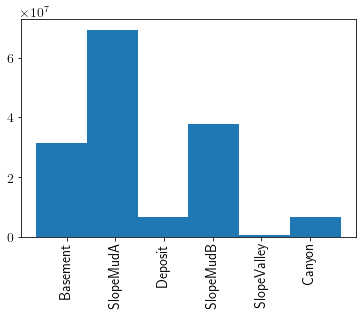

In [5]:
plt.hist(label.ravel(), 6)
plt.xticks(np.linspace(0.5,4.5,num_classes), CLASS_NAMES, rotation=90)
plt.show()

Classes are quite unbalanced! There's little or no class 4

## Data Loaders

In [6]:
pe = PE(dim=(992,128), stride=(2,32))

In [7]:
patches_img = []
patches_msk = []
for inline in range(image.shape[1]):
    patches_img.append(pe.extract(image[:,inline].T))
    patches_msk.append(pe.extract(label[:,inline].T))
    
patches_img = np.asarray(patches_img).reshape((-1,)+pe.dim+(1,))
patches_msk = np.asarray(patches_msk).reshape((-1,)+pe.dim+(1,))

In [8]:
in_min = patches_img.min()
in_max = patches_img.max()
normalization = lambda x: normalize_only(x, in_min=in_min, in_max=in_max, zero_mean=True)

In [9]:
bound = patches_img.shape[0]//2

In [10]:
train_gen = d.PatchArrayLoader(batch_size=32,
                               input_array=patches_img[:bound],
                               target_array=patches_msk[:bound],
                               input_transform=normalization,
                               target_transform=to_categorical)

val_gen = d.PatchArrayLoader(batch_size=32,
                       input_array=patches_img[bound:],
                       target_array=patches_msk[bound:],
                       input_transform=normalization,
                       target_transform=to_categorical)

#### Model

In [11]:
# Build model
K.clear_session()
model = a.Xception(pe.dim+(1,), num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 992, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 496, 64, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 496, 64, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 496, 64, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(optimizer="rmsprop", loss='bce')

In [13]:
callbacks = [
    ModelCheckpoint("test3_weights.h5", save_best_only=True),
    # EarlyStopping(patience=5),
]

In [14]:
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10, callbacks=callbacks, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 480 steps, validate for 480 steps
Epoch 1/10
480/480 [==============================] - 467s 972ms/step - loss: 0.1032 - val_loss: 2.4866
Epoch 2/10
480/480 [==============================] - 457s 951ms/step - loss: 0.0269 - val_loss: 0.0680
Epoch 3/10
480/480 [==============================] - 456s 951ms/step - loss: 0.0180 - val_loss: 0.0704
Epoch 4/10
480/480 [==============================] - 455s 947ms/step - loss: 0.0149 - val_loss: 0.0776
Epoch 5/10
480/480 [==============================] - 446s 930ms/step - loss: 0.0130 - val_loss: 0.0821
Epoch 6/10
480/480 [==============================] - 450s 938ms/step - loss: 0.0124 - val_loss: 0.0862
Epoch 7/10
480/480 [==============================] - 449s 935ms/step - loss: 0.0113 - val_loss: 0.0759
Epoch 8/10
480/480 [==============================] - 449s 935ms/step - loss: 0.0101 - val_loss: 0.0796
Epoch 9/10
480/480 [==============================] - 449s 935ms/step - lo

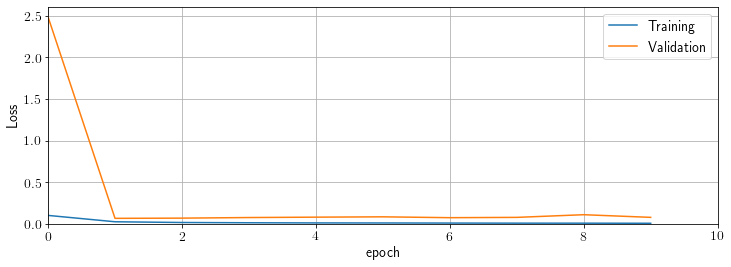

In [15]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlim(0,10)
plt.ylim(0)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Visualize

In [16]:
img, msk = train_gen[0][0][0], train_gen[0][1][0]
out = model.predict(img[np.newaxis]).squeeze()

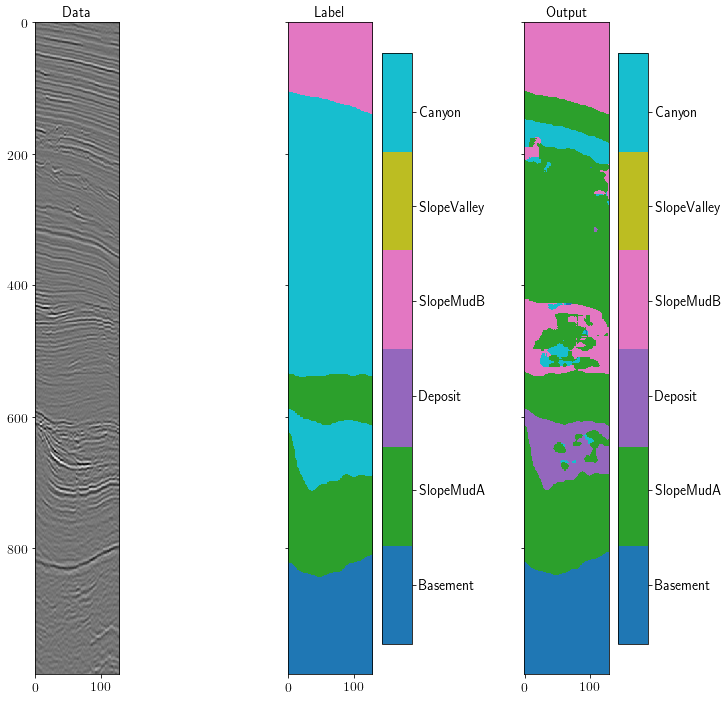

In [17]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 12))

data=axs[0].imshow(img.squeeze())
axs[0].set_title('Data')

plot_label(np.argmax(msk, axis=-1),
           fig, axs[1], num_classes, labels=CLASS_NAMES)
axs[1].set_title('Label')

plot_label(np.argmax(out, axis=-1).squeeze(),
           fig, axs[2], num_classes, labels=CLASS_NAMES)
axs[2].set_title('Output')

plt.show()

In [18]:
img, msk = val_gen[0][0][0], val_gen[0][1][0]
out = model.predict(img[np.newaxis]).squeeze()

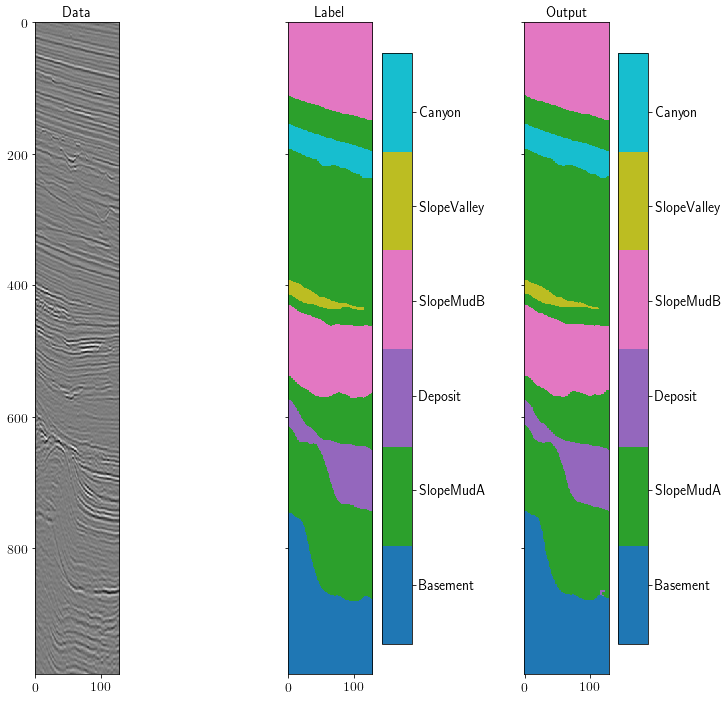

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 12))

data=axs[0].imshow(img.squeeze())
axs[0].set_title('Data')

plot_label(np.argmax(msk, axis=-1),
           fig, axs[1], num_classes, labels=CLASS_NAMES)
axs[1].set_title('Label')

plot_label(np.argmax(out, axis=-1).squeeze(),
           fig, axs[2], num_classes, labels=CLASS_NAMES)
axs[2].set_title('Output')

plt.show()

## Test

In [21]:
test_image = np.load(os.path.join(dataset, "train_image.npy"))[:,-1,:]
test_label = np.load(os.path.join(dataset, "train_labels.npy"))[:,-1,:].astype(np.uint8)-1

In [22]:
patch_img = pe.extract(test_image.T).reshape((-1,)+pe.dim+(1,))
patch_msk = pe.extract(test_label.T).reshape((-1,)+pe.dim+(1,))

In [25]:
patch_out = model.predict(normalize(patch_img, in_min, in_max)[0])

In [26]:
patch_out_max = np.argmax(patch_out, axis=-1)

In [27]:
out = pe.reconstruct(patch_out_max.reshape(pe.patch_array_shape))

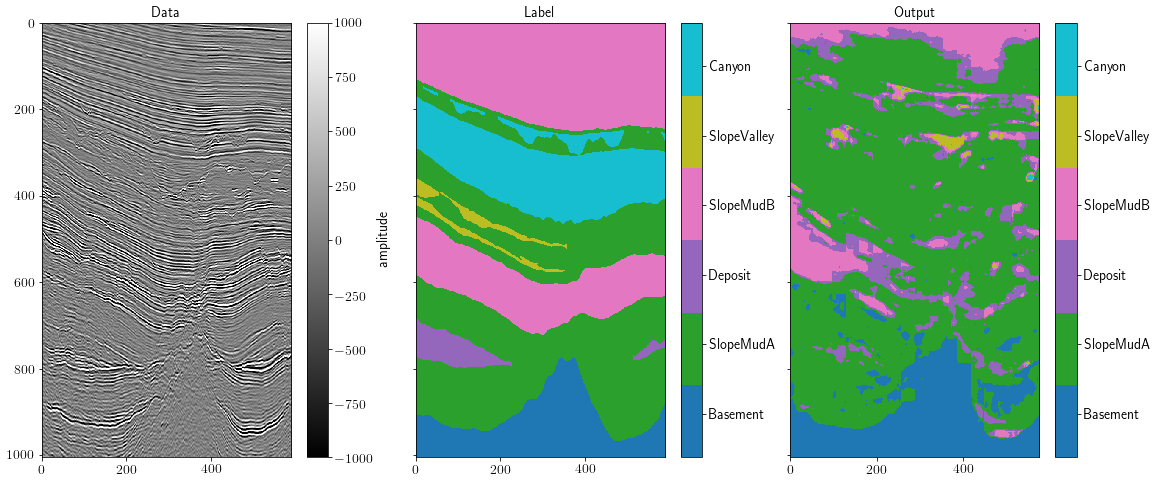

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(19, 8))

data=axs[0].imshow(test_image.T, clim=(-1000,1000))
axs[0].set_title('Data')
axs[0].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')

plot_label(test_label.T, fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[1].set_title('Label')
axs[1].axis('tight')

plot_label(out, fig, axs[2], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[2].set_title('Output')
axs[2].axis('tight')
           
plt.show()